In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import concurrent.futures
from threading import Lock
import json, math, random, os, pprint
#from kaggle_datasets import KaggleDatasets
from matplotlib import pyplot as plt
import matplotlib as mpl
import utils_box as box
AUTO = tf.data.AUTOTUNE
pp = pprint.PrettyPrinter()

# TPU detection

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPU(s) and enable mixed precision
    strategy = tf.distribute.MirroredStrategy() # works on GPU and multi-GPU
    
print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: martin-tpuv3-8-tf24


INFO:tensorflow:Initializing the TPU system: martin-tpuv3-8-tf24


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [3]:
GCS_PATH = "gs://kds-fcd719b9a95fc49a89eb7d4330bce3117c82cf534fe41821acc3bce8"
print(GCS_PATH)

gs://kds-fcd719b9a95fc49a89eb7d4330bce3117c82cf534fe41821acc3bce8


In [73]:
class Progress:
    """Text mode progress bar.
    Usage:
            p = Progress(30)
            p.step()
            p.step()
            p.step(start=True) # to restart form 0%
    The progress bar displays a new header at each restart."""
    def __init__(self, maxi, size=100, msg=""):
        """
        :param maxi: the number of steps required to reach 100%
        :param size: the number of characters taken on the screen by the progress bar
        :param msg: the message displayed in the header of the progress bat
        """
        self.maxi = maxi
        self.p = self.__start_progress(maxi)()  # () to get the iterator from the generator
        self.header_printed = False
        self.msg = msg
        self.size = size
        self.lock = Lock()

    def step(self, reset=False):
        with self.lock:
            if reset:
                self.__init__(self.maxi, self.size, self.msg)
            if not self.header_printed:
                self.__print_header()
            next(self.p)

    def __print_header(self):
        print()
        format_string = "0%{: ^" + str(self.size - 6) + "}100%"
        print(format_string.format(self.msg))
        self.header_printed = True

    def __start_progress(self, maxi):
        def print_progress():
            # Bresenham's algorithm. Yields the number of dots printed.
            # This will always print 100 dots in max invocations.
            dx = maxi
            dy = self.size
            d = dy - dx
            for x in range(maxi):
                k = 0
                while d >= 0:
                    print('=', end="", flush=True)
                    k += 1
                    d -= dx
                d += dy
                yield k

        return print_progress

    
def no_decorations(ax):
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    

def display_detections(images, offsets, resizes, detections, classnames, ground_truth_boxes=[]):
    # scale and offset the detected boxes back to original image coordinates
    boxes   = [[ (x,y,w,h)  for _, x, y, w, h, score, klass in detection_list] for detection_list in detections]
    boxes   = [[ (x-ofs[1], y-ofs[0], w, h) for x,y,w,h in boxlist ] for boxlist, ofs in zip(boxes, offsets)]
    boxes   = [[ (x*rsz, y*rsz, w*rsz, h*rsz) for x,y,w,h in boxlist ] for boxlist, rsz in zip(boxes, resizes)]
    classes = [[ int(klass) for _, x, y, w, h, score, klass in detection_list] for detection_list in detections]
    scores  = [[ score      for _, x, y, w, h, score, klass in detection_list] for detection_list in detections]
    display_with_boxes(images, boxes, classes, scores, classnames, ground_truth_boxes)
    
    
# images, boxes and classes must have the same number of elements
# scores can be en empty list []. If it is not empty, it must also
# have the same number of elements.
# classnames is the list of possible classes (strings)
def display_with_boxes(images, boxes, classes, scores, classnames, ground_truth_boxes=[]):
    N = len(images)
    sqrtN = int(math.ceil(math.sqrt(N)))
    fig = plt.figure(figsize=(15,15), frameon=False)
    
    for k in range(N):
        ax = plt.subplot(sqrtN, sqrtN, k+1)
        no_decorations(ax)
        plt.imshow(images[k])
        
        if ground_truth_boxes:
            for box in ground_truth_boxes[k]:
                x, y, w, h = (box[0], box[1], box[2]-box[0], box[3]-box[1]) # convert x1 y1 x2 y2 into xywh
                #x, y, w, h = (box[0], box[1], box[2], box[3])
                rect = mpl.patches.Rectangle((x, y),w,h,linewidth=4,edgecolor='#FFFFFFA0',facecolor='none')
                ax.add_patch(rect)

        for i, (box, klass) in enumerate(zip(boxes[k], classes[k])):
            x, y, w, h = (box[0], box[1], box[2]-box[0], box[3]-box[1]) # convert x1 y1 x2 y2 into xywh
            #x, y, w, h = (box[0], box[1], box[2], box[3])
            label = classnames[klass-1] # predicted classes are 1-based
            if scores:
                label += ' ' + str(int(scores[k][i]*100)) + '%' 
            rect = mpl.patches.Rectangle((x, y),w,h,linewidth=4,edgecolor='#00000080',facecolor='none')
            ax.add_patch(rect)
            rect = mpl.patches.Rectangle((x, y),w,h,linewidth=2,edgecolor='#FFFF00FF',facecolor='none')
            ax.add_patch(rect)
            plt.text(x, y, label, size=16, ha="left", va="top", color='#FFFF00FF',
                     bbox=dict(boxstyle="round", ec='#00000080', fc='#0000004E', linewidth=3) )
            plt.text(x, y, label, size=16, ha="left", va="top", color='#FFFF00FF',
                     bbox=dict(boxstyle="round", ec='#FFFF00FF', fc='#0000004E', linewidth=1.5) )
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    plt.show()

# Load metadata

In [5]:
# load all the metadata
#DATA_PATH='../input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/'
DATA_PATH = GCS_PATH + '/ArTaxOr/'

json_filename_pattern = DATA_PATH+'*/annotations/*.json'
jpeg_filename_pattern = DATA_PATH+'*/*.jpg'

def load_json(filename, p):
    p.step()
    with tf.io.gfile.GFile(filename, 'r') as f:
        return json.load(f)
    
def filename_key(filename):
    path, filename = os.path.split(filename)
    dirname = os.path.split(path)[1]
    return os.path.join(dirname, filename)
    
def load_metadata(filename_pattern, jpeg_filename_pattern):
    print("Scanning directory...", end=' ')
    json_filenames = tf.io.gfile.glob(json_filename_pattern)
    jpeg_filenames = tf.io.gfile.glob(jpeg_filename_pattern)
    print(f"found {len(json_filenames)} metadata files and {len(jpeg_filenames)} image files.")
    print("Loading metadata")
    p = Progress(len(json_filenames))
    with concurrent.futures.ThreadPoolExecutor() as exe:
        data = exe.map(lambda x: load_json(x,p), json_filenames)
    # data as a dictionary for easier cross-referencing
    data = {filename_key(d['asset']['path']):d for d in data}
    return data, jpeg_filenames

raw_metadata, jpeg_filenames = load_metadata(json_filename_pattern, jpeg_filename_pattern)

Scanning directory... found 15376 metadata files and 15376 image files.
Loading metadata

0%                                                                                              100%

In [6]:
pp.pprint(raw_metadata['Hymenoptera/27c544074ca6.jpg'])

{'asset': {'format': 'jpg',
           'id': '3b6a950e0641881100766c33e7854168',
           'name': '27c544074ca6.jpg',
           'path': 'file:F:/ArTaxOr/Hymenoptera/27c544074ca6.jpg',
           'size': {'height': 1845, 'width': 2048},
           'state': 2,
           'type': 1},
 'regions': [{'boundingBox': {'height': 183.79310344827584,
                              'left': 590.0811044003451,
                              'top': 1192.8879310344828,
                              'width': 217.34598792062124},
              'id': 'O9mVZefOx',
              'points': [{'x': 590.0811044003451, 'y': 1192.8879310344828},
                         {'x': 807.4270923209664, 'y': 1192.8879310344828},
                         {'x': 807.4270923209664, 'y': 1376.6810344827586},
                         {'x': 590.0811044003451, 'y': 1376.6810344827586}],
              'tags': ['Hymenoptera'],
              'type': 'RECTANGLE'},
             {'boundingBox': {'height': 205,
                       

# Statistics

In [7]:
print('Nb entries:', len(raw_metadata))
print('Nb images:', len(jpeg_filenames))
assert(len(raw_metadata) == len(jpeg_filenames))

formats = set([d['asset']['format'] for k,d in raw_metadata.items()])
print('Image formats:', formats)
assert(len(formats)==1 and list(formats)[0]=='jpg')

states = set([d['asset']['state'] for k,d in raw_metadata.items()])
print('Image states(?):', states)
types = set([d['asset']['type'] for k,d in raw_metadata.items()])
print('Image types(?):', types)

widths = [d['asset']['size']['width'] for k,d in raw_metadata.items()]
print(f'Images widths range from {min(widths)} to {max(widths)}')
heights = [d['asset']['size']['height'] for k,d in raw_metadata.items()]
print(f'Images heights range from {min(heights)} to {max(heights)}')

aspect_ratios = [w/h for w,h in zip(widths, heights)]
print(f'Images aspect ratios range from {min(aspect_ratios)} to {max(aspect_ratios)}')

nbbox = [len(d['regions']) for k,d in raw_metadata.items()]
print(f'Nb of bounding boxes from {min(nbbox)} to {max(nbbox)}, average {sum(nbbox)/len(nbbox):.3}')

region_types = [set([t['type'] for t in d['regions']]) for k,d in raw_metadata.items()]
region_types = set().union(*region_types)
print('Region types:', region_types)
assert(len(region_types)==1 and list(region_types)[0]=='RECTANGLE')

region_tags = [[t['tags'] for t in d['regions']] for k,d in raw_metadata.items()]
region_tags = [sum(l,[]) for l in region_tags] # concat lists of tags across multiple regions
region_tags = set(sum(region_tags, [])) # concat all and make a set
print('Region tags:', region_tags)

bbox_width = [[t['boundingBox']['width'] for t in d['regions']] for k,d in raw_metadata.items()]
bbox_width = sum(bbox_width, []) # flatten the list
print(f'Bounding box widths range from {min(bbox_width)} to {max(bbox_width)}')

bbox_height = [[t['boundingBox']['height'] for t in d['regions']] for k,d in raw_metadata.items()]
bbox_height = sum(bbox_height, []) # flatten the list
print(f'Bounding box height range from {min(bbox_height)} to {max(bbox_height)}')

bbox_left = [[t['boundingBox']['left'] for t in d['regions']] for k,d in raw_metadata.items()]
bbox_left = sum(bbox_left, []) # flatten the list
print(f'Bounding box left range from {min(bbox_left)} to {max(bbox_left)}')

bbox_top = [[t['boundingBox']['top'] for t in d['regions']] for k,d in raw_metadata.items()]
bbox_top = sum(bbox_top, []) # flatten the list
print(f'Bounding box top range from {min(bbox_top)} to {max(bbox_top)}')

# compute aspect ratios in landscape mode
landscape_aspect_ratios = [w/h if w>h else h/w for w,h in zip(widths, heights)]
print(f'Images landscape aspect ratios range from {min(landscape_aspect_ratios)} to {max(landscape_aspect_ratios)}')

Nb entries: 15376
Nb images: 15376
Image formats: {'jpg'}
Image states(?): {2}
Image types(?): {1}
Images widths range from 500 to 6300
Images heights range from 375 to 5472
Images aspect ratios range from 0.4044418468731736 to 2.8656716417910446
Nb of bounding boxes from 1 to 49, average 1.28
Region types: {'RECTANGLE'}
Region tags: {'Hemiptera', 'Lepidoptera', '_blurred', 'Diptera', 'Hymenoptera', 'Araneae', '_occluded', 'Odonata', 'Coleoptera', '_truncated'}
Bounding box widths range from 17.213793103448275 to 4644.148965517242
Bounding box height range from 13.226141078838173 to 3655.1724137931033
Bounding box left range from 0 to 5313.113714679532
Bounding box top range from 0 to 3659.5862068965516
Images landscape aspect ratios range from 1.0 to 2.8656716417910446


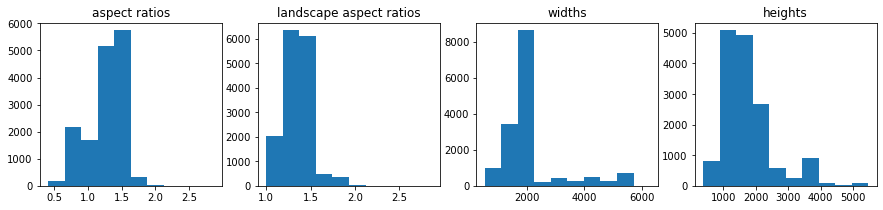

In [8]:
fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize=(15,3))
ax1.set_title("aspect ratios")
ax1.hist(aspect_ratios)
ax2.set_title("landscape aspect ratios")
ax2.hist(landscape_aspect_ratios)
ax3.set_title("widths")
ax3.hist(widths)
ax4.set_title("heights")
ax4.hist(heights)
plt.show()

In [9]:
# collect weird aspec ratio images and very large images
oddities = [d['asset']['path'] for k,d in raw_metadata.items() if d['asset']['size']['width']>5400]
oddities += [d['asset']['path'] for k,d in raw_metadata.items() if d['asset']['size']['height']>5000]
oddities2 = [d['asset']['path'] for k,d in raw_metadata.items() if d['asset']['size']['height']/d['asset']['size']['width']>1.9]
oddities2 += [d['asset']['path'] for k,d in raw_metadata.items() if d['asset']['size']['width']/d['asset']['size']['height']>2.0]

oddities = [DATA_PATH+filename_key(s) for s in oddities]
oddities2 = [DATA_PATH+filename_key(s) for s in oddities2]

# Dataset

In [96]:
filenames = [
    '../input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Hymenoptera/f8f10bc28f5b.jpg',
    '../input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Lepidoptera/e314c31efafd.jpg']
#filenames = jpeg_filenames
filenames = oddities2
values = [raw_metadata[filename_key(f)] for f in filenames]

values = {'key': [filename_key(val['asset']['path']) for val in values],
          'fname': [os.path.join(DATA_PATH, filename_key(val['asset']['path'])) for val in values],
          'width':[val['asset']['size']['width'] for val in values],
          'height':[val['asset']['size']['height'] for val in values],
          # internal box format: x1 y1 x2 y2
          'boxes': tf.ragged.constant([[(item['boundingBox']['left'],
                                         item['boundingBox']['top'],
                                         item['boundingBox']['left']+item['boundingBox']['width'],
                                         item['boundingBox']['top']+item['boundingBox']['height']) 
                                        for item in val['regions']]
                                       for val in values], ragged_rank=1), # must specify ragged rank, othewise tf.ragged.constant
                                                                           # does not detect that the last dim is 4 [x1 y1 x2 y2]
           'tags': tf.ragged.constant([[item['tags']
                                        for item in val['regions']]
                                       for val in values])
          }

metadataset = tf.data.Dataset.from_tensor_slices(values)

In [135]:
MAX_BOXES = 50
TARGET_SIZE = [1024, 724]

def decode_img(metadata):
    compressed_data = tf.io.read_file(metadata['fname'])
    image = tf.image.decode_jpeg(compressed_data, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32) # convert from uint8 [0,255] float [0,1)
    return image, metadata

# Returns two crop_boxes. The first is the preferred crop box,
# the second one is an alternative.
# output format: x1 y1 x2 y2 in relative image coordinates
def compute_crop_boxes(image_size, target_aspect_ratio):
    W = image_size[0]
    w = target_aspect_ratio[0]
    H = image_size[1]
    h = target_aspect_ratio[1]
    # box with desired aspect ration that fits in the image horizontally
    crop_box1 = [0.0, (1-W/w*h/H)/2.0, 1.0, (1+W/w*h/H)/2.0] # format x1 y1 x2 y2
    # box with desired aspect ration that fits in the image vertically
    crop_box2 = [(1-w/W*H/h)/2.0, 0.0, (1+w/W*H/h)/2.0, 1.0] # format x1 y1 x2 y2
    # select the box that crops the image, not the one that adds black borders
    return tf.cond(crop_box1[1]>0, lambda:(crop_box1, crop_box2), lambda:(crop_box2, crop_box1))

def resize_image_and_boxes(im, metadata):
    boxes = tf.cast(metadata['boxes'], tf.float32) # the number of boxes is ragged but for one image it is constant
    image_size = tf.cast([metadata['width'], metadata['height']], tf.float32)
    crop_boxes = compute_crop_boxes(image_size, TARGET_SIZE)
    
    # select the cropping method so as not to lose any bounding box
    tiles = box.scale_rois(crop_boxes, image_size) # convert to absolute image coordinates
    _, is_roi_in_tile = box.find_non_intersecting_rois(tiles, boxes) # [n_tiles, n_rois]
    crop_box = tf.cond(tf.reduce_all(is_roi_in_tile[0]), lambda: crop_boxes[0], lambda:crop_boxes[1])
    
    # resize image
    crop_box_for_tfimage = box.swap_xy(crop_box) # tf.image.crop_and_resize expects y1 x1 y2 x2 coordinates
    crop_box_for_tfimage = tf.expand_dims(crop_box_for_tfimage, axis=0) # tf.image.crop_and_resize expects a list of boxes
    box_indices = tf.zeros([1], tf.int32) # all boxes refer to the same image
    images = tf.expand_dims(im, axis=0) # tf.image.crop_and_resize expects a batch of images
    images = tf.image.crop_and_resize(images, crop_box_for_tfimage, box_indices, [TARGET_SIZE[1], TARGET_SIZE[0]])
    im = tf.squeeze(images, axis=0)
    
    # resize and pad boxes
    tiles = box.scale_rois(crop_box, image_size) # convert to absolute image coordinates
    tiles = tf.expand_dims(tiles, axis=0) # box.rois_in_tiles_relative expects a list of tiles (we have one)
    boxes = box.rois_in_tiles_relative_and_pad(tiles, boxes, MAX_BOXES)
    boxes = tf.squeeze(boxes, axis=0) # we have only want crop tile
    boxes = box.scale_rois(boxes, tf.cast(TARGET_SIZE, tf.float32))
    boxes = tf.cast(tf.round(boxes), tf.int32)
    return im, boxes
    
dataset = metadataset.map(decode_img, num_parallel_calls=AUTO)
dataset = dataset.map(resize_image_and_boxes, num_parallel_calls=AUTO)

In [136]:
CLASSES = ['Lepidoptera', 'Hymenoptera', 'Hemiptera', 'Odonata', 'Diptera', 'Araneae', 'Coleoptera',
           '_truncated', '_blurred', '_occluded', ]
dataset_iterator = iter(dataset.batch(4))

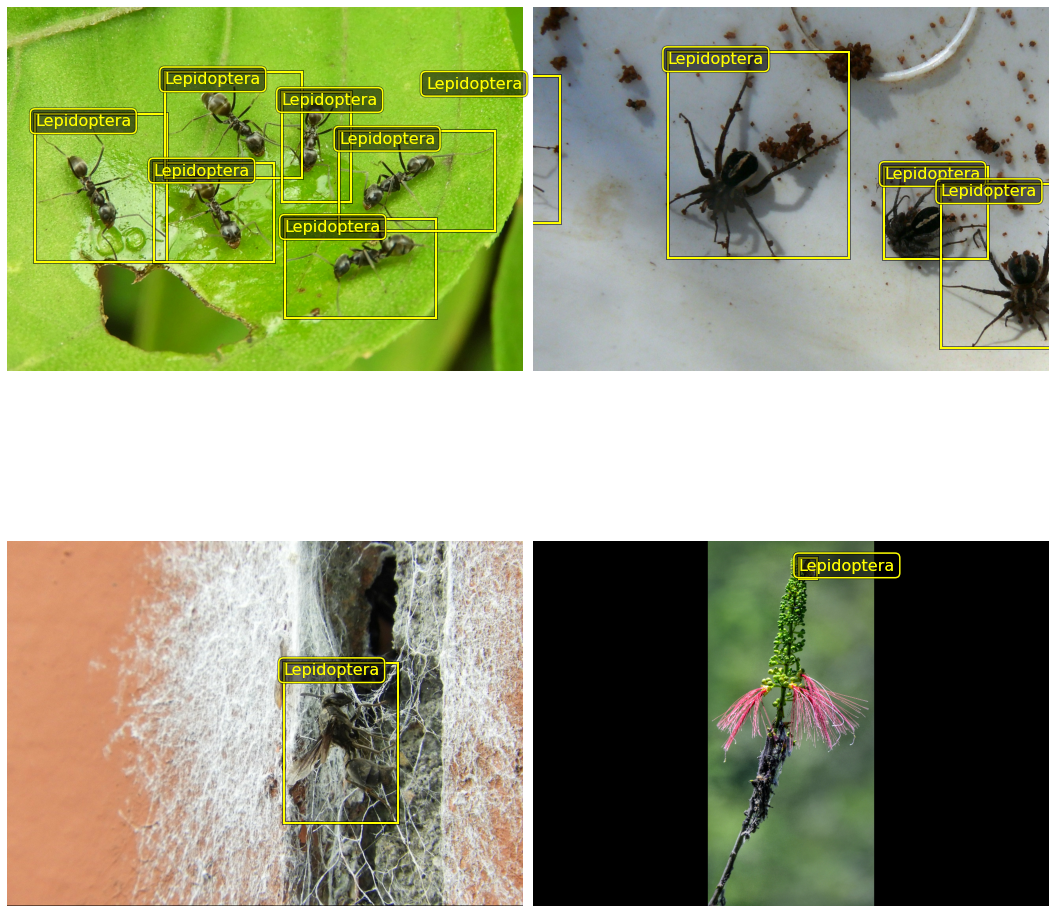

In [140]:
images, boxes  = next(dataset_iterator)
boxes = [[list(box.numpy()) for box in boxlist if not (box[0]==0 and box[1]==0 and box[2]==0 and box[3]==0)] for boxlist in boxes]
fake_tags = [[1 for box in boxlist] for boxlist in boxes] 
display_with_boxes(images, boxes, fake_tags, None, CLASSES, ground_truth_boxes=[])

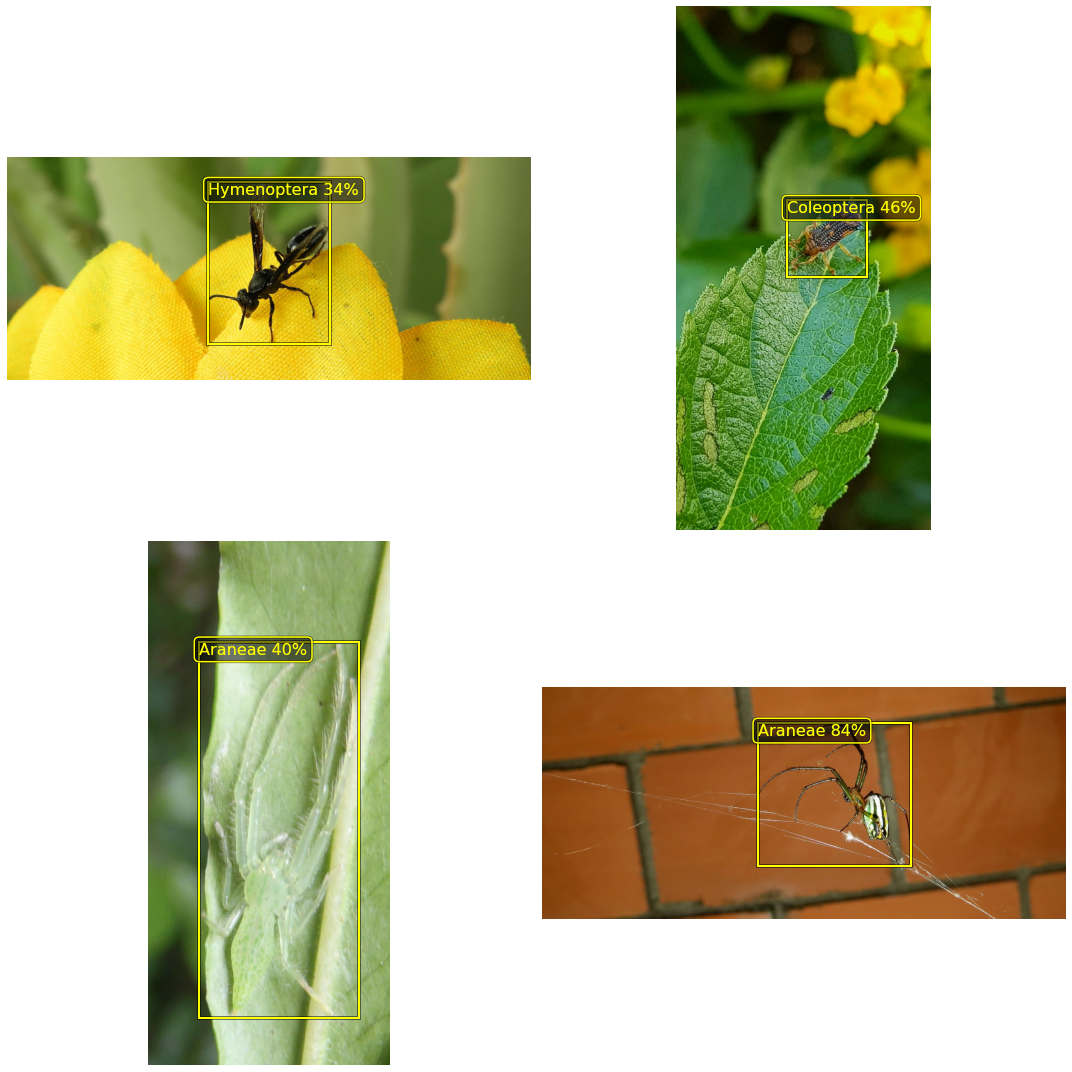

In [112]:
CLASSES = ['Lepidoptera', 'Hymenoptera', 'Hemiptera', 'Odonata', 'Diptera', 'Araneae', 'Coleoptera',
           '_truncated', '_blurred', '_occluded', ]

nice_pics = ['../input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Lepidoptera/e7d7b4678088.jpg',
'../input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Lepidoptera/e74f298859ff.jpg',
'../input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Coleoptera/92c9a15e7362.jpg',
'../input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Coleoptera/a1824522fddc.jpg',
'../input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Hymenoptera/7188c0cc8c9d.jpg',
'../input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Lepidoptera/b7197aead30b.jpg',
'../input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Lepidoptera/dfc9ece476e6.jpg',
'../input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Araneae/a1488eb130e3.jpg',
'../input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Coleoptera/39c0eabccc41.jpg']

alt_pic = ['gs://kds-fcd719b9a95fc49a89eb7d4330bce3117c82cf534fe41821acc3bce8/ArTaxOr/Araneae/3c6491416c3f.jpg',
           'gs://kds-fcd719b9a95fc49a89eb7d4330bce3117c82cf534fe41821acc3bce8/ArTaxOr/Araneae/81ff08857d15.jpg']

#filenames = tf.io.gfile.glob('../input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/*/*jpg')
#filenames = nice_pics
filenames = oddities2
#filenames = alt_pic

images = []
bboxes = []
taglists = []
#random.shuffle(filenames)
for filename in filenames[24:28]:
    d = raw_metadata[filename_key(filename)]
    images.append(tf.image.decode_jpeg(tf.io.read_file(filename)))
    bbxs = [region['boundingBox'] for region in d['regions']]
    bbxs = [[box['left'],box['top'], box['left']+box['width'], box['top']+box['height']] for box in bbxs]
    tags = [region['tags'] for region in d['regions']] # all tags
    tags = [region['tags'][0] for region in d['regions']] # first tag only
    tags = [CLASSES.index(t)+1 for t in tags] 
    bboxes.append(bbxs)
    taglists.append(tags)

confids = [[random.uniform(0.2, 0.99) for _ in range(len(b))] for b in bboxes] # fake
display_with_boxes(images, bboxes, taglists, confids, CLASSES, ground_truth_boxes=[])

# Model

In [15]:
with strategy.scope():
    load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
    detector = hub.KerasLayer("https://tfhub.dev/tensorflow/efficientdet/d6/1", load_options=load_locally)

In [18]:
filename = filenames[0]

with open(filename, "rb") as f:
    im = tf.image.decode_jpeg(f.read())
    im = tf.expand_dims(im, axis=0)
    detector_output = detector(im)
    
print(detector_output)

InvalidArgumentError: Dst node should be assigned to an allowed device. Found an edge from node StatefulPartitionedCall/WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/ReadVariableOp assigned to /job:localhost/replica:0/task:0/device:COMPOSITE:0 to node StatefulPartitionedCall/WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/FusedBatchNormV3 assigned to /job:worker/replica:0/task:0/device:CPU:0

In [17]:
# detect
CUTOFF = 0.13
detections = zip(detector_output['detection_boxes'][0], detector_output['detection_scores'][0])
detections = [(box.numpy(), score.numpy()) for box,score in detections if score.numpy()>CUTOFF]
d_box = d_conf = [[]]
if detections:
    d_box, d_conf = zip(*detections)
    d_box = [list(d_box)]
    d_conf = [list(d_conf)]
    print(d_box)
    print(d_conf)
    
# find ground truth boxes in data
gt_bboxes = []
for d in data:
    if filename.endswith(d['asset']['name']):
        bbxs = [region['boundingBox'] for region in d['regions']]
        bbxs = [[box['left'],box['top'], box['width'], box['height']] for box in bbxs]
        w = d['asset']['size']['width']
        h = d['asset']['size']['height']
        gt_bboxes.append(bbxs)
        for i, box in enumerate(d_box[0]):
            d_box[0][i] = [box[1]*w, box[0]*h, box[3]*w-box[1]*w, box[2]*h-box[0]*h]
        
display_with_boxes(im, d_box, [[1,1,1,1]], d_conf, ['thing'], ground_truth_boxes=gt_bboxes)

InvalidArgumentError: Dst node should be assigned to an allowed device. Found an edge from node StatefulPartitionedCall/WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/ReadVariableOp assigned to /job:localhost/replica:0/task:0/device:COMPOSITE:0 to node StatefulPartitionedCall/WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/FusedBatchNormV3 assigned to /job:worker/replica:0/task:0/device:CPU:0 [Op:StridedSlice] name: strided_slice/